# Full updated code : From Tray images to pot images

## Library imports

In [2]:
from skimage import feature, color, filters, measure, io, segmentation
import cv2
import numpy as np
from scipy.ndimage import distance_transform_edt

import matplotlib.pyplot as plt
from scipy import ndimage as nd
from skimage.color import label2rgb
import pandas as pd

# Auxillary functions

In [19]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

# Image raw segmentation

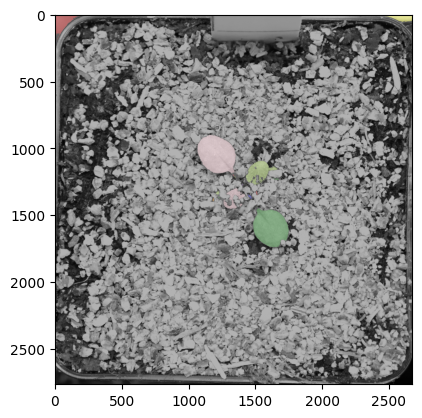

In [5]:
#Image path
img=io.imread('/home/mcaroulle/Pheno_Leaf/Data/Cropped/1.png')

#convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#create a mask using green color as a threshold
mask= cv2.inRange(hsv,(30,20,150),(70,255,255))

#binaryzation of the mask
closed_mask = nd.binary_closing(mask, np. ones ((7,7)))

#labeling segmented objects
label_image= measure.label(closed_mask)

#plot both image ad segmentation result
image_label_overlay = label2rgb(label_image, image= img)
plt.imshow(image_label_overlay) 

#collect poperties (area, label,… ) of the segmented objects 
props = measure.regionprops_table(label_image, img, 
                                  properties=['label','area','centroid','coords'])

#convertion of segmented object propoerties into a dataframe
df = pd.DataFrame(props)
#print(df.head())

## Segmentation filtering

### Filtering by area

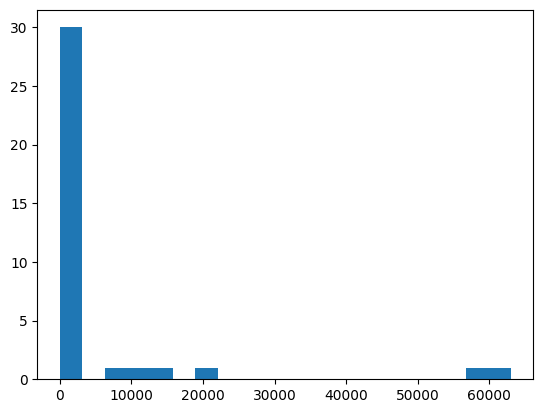

In [14]:
#plot object areas
area = df['area']
plt.hist(area,20)
plt.show()

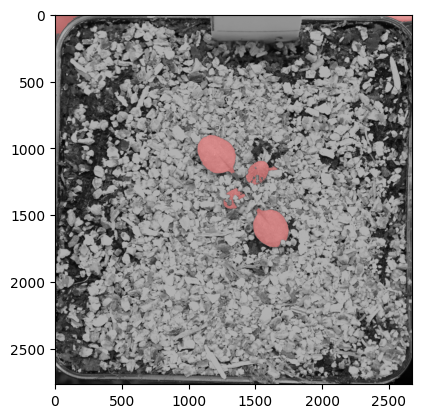

In [16]:
# Filter regions with greater than 9000
df_filtered = df[df['area'] > 9000]

# Filter label_image based on the filtered DataFrame
filtered_label_image = np.isin(cleared_label_image , df_filtered['label'])

image_label_overlay = label2rgb(filtered_label_image, image= img)
plt.imshow(image_label_overlay)

### Plant merging

#### Fonction to coin an image from a mask
Input:
    mask : array 
    
Output:
    image

In [18]:
def from_mask_to_image(mask):
    #Create empty image with same dimensions as the mask
    image = np.zeros_like(mask)

    #Apply the mask to the image by defining white pixels
    image[mask > 0] = 255

    return image

#### Location of segmented objects

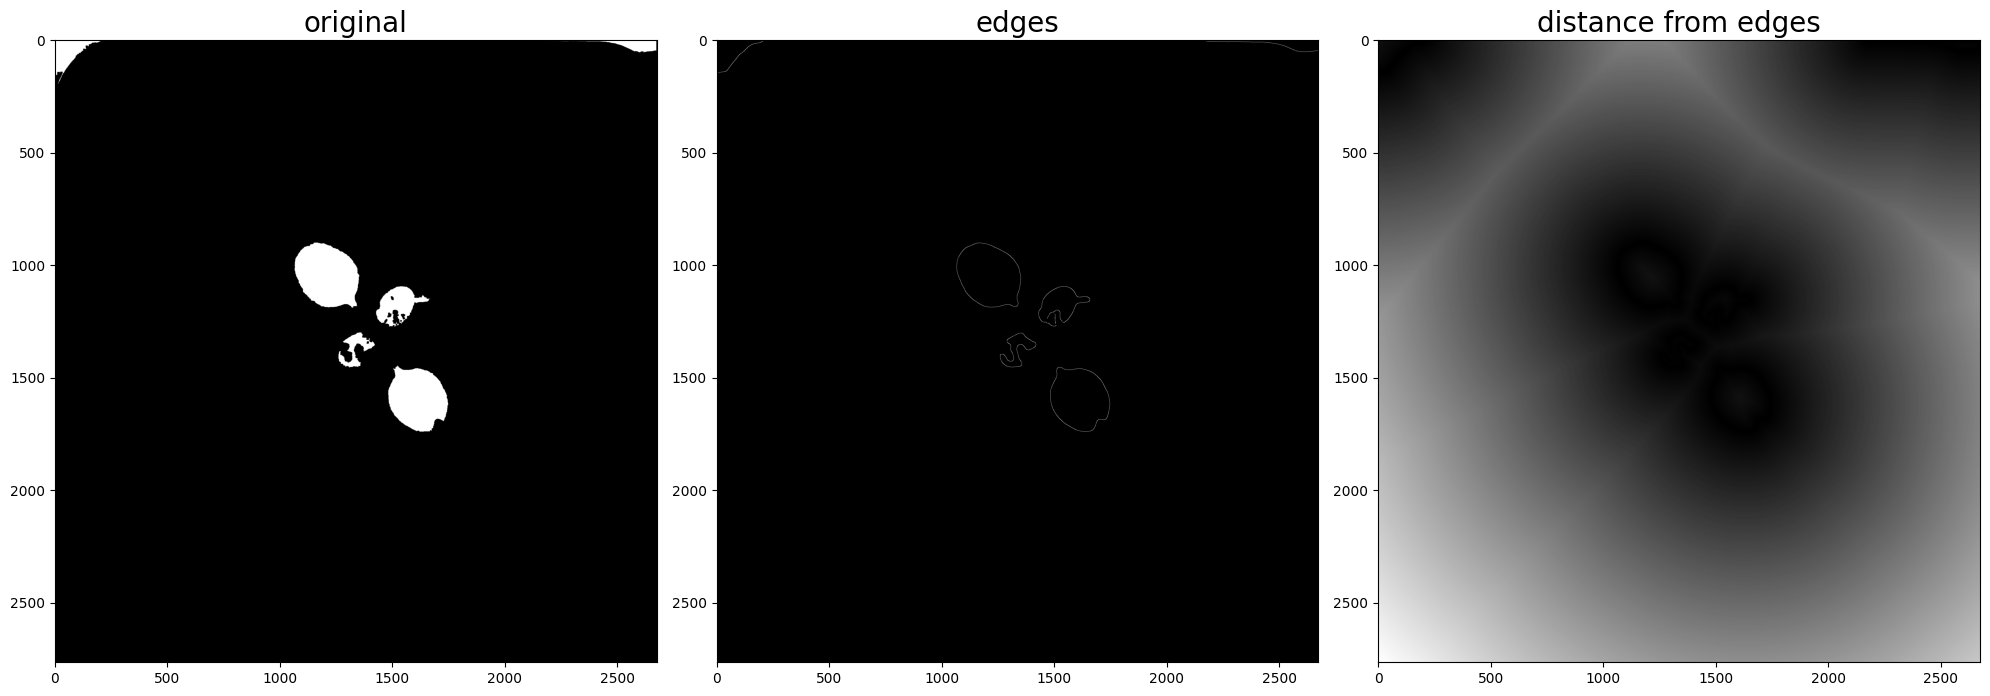

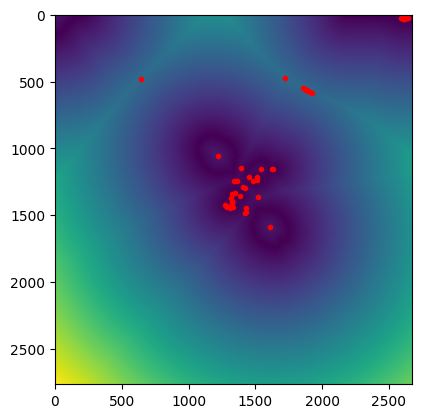

In [22]:
#coin an image from a mask
image = from_mask_to_image(filtered_label_image)

#detect edges
edges = feature.canny(image, sigma=10)

#calculate distances from edges
dt = distance_transform_edt(~edges)

#determine local maximum with calculate distance from edges
peak_idx = feature.peak_local_max(dt, min_distance=5)

#display outputs
show_image_list(list_images=[image, edges, dt], 
                list_titles=['original', 'edges', 'distance from edges'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)

plt.plot(peak_idx[:,1],peak_idx[:,0],'r.')
plt.imshow(dt)

#### Generate a dataframe with peaks coords

In [ ]:
df_peak = pd.DataFrame(peak_idx)
df_peak.columns=['x_coord','y_coord']
df_peak['index_of_label_in_df_coords']=''
df_peak['label']=''

#### Generate a dataframe with label coords

In [ ]:
df_filtered_reinit=df_filtered.reset_index(drop=True) #reset of indexes

df_coords=df_filtered_reinit[['label','coords']]

### L